# Projet Deep Learning : Pi-Model


### Load the useful packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

'1.15.0'

In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Load the data

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K

In [ ]:
K.set_image_data_format('channels_last')
(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data()
print('x_train shape:', x_train_original.shape)
print(x_train_original.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [ ]:
num_classes = y_train_original.max() +1
num_classes

10

### Preprocess the data

- Data cleaning
- Data conversion
- Data normalization
- Data split

#### Data split.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_original, y_train_original, test_size=1000, random_state=42, shuffle= True,stratify=y_train_original)

#### Convert class vectors to binary class matrices.

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_original = to_categorical(y_train_original, num_classes)
y_test = to_categorical(y_test, num_classes)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

#### Normalize the data

In [ ]:
# The data must be converted into float in order to normalize them.
x_train_original = x_train_original.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')

x_train_original /= 255
x_test /= 255
x_train /= 255
x_val /= 255

### Adapt shapes and display digits

In [ ]:
tf.reset_default_graph()

In [ ]:
print(x_train.shape)
print(y_train.shape)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)

print(x_train.shape)

(59000, 28, 28)
(59000, 10)
(59000, 28, 28, 1)


In [ ]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(59000, 28, 28, 1)
(1000, 28, 28, 1)
(10000, 28, 28, 1)


In [ ]:
n_input =x_train.shape[1]*x_train.shape[2]
n_hidden_1 = 128
n_hidden_2 = 64
n_classes = y_train.shape[1]
n_input

784

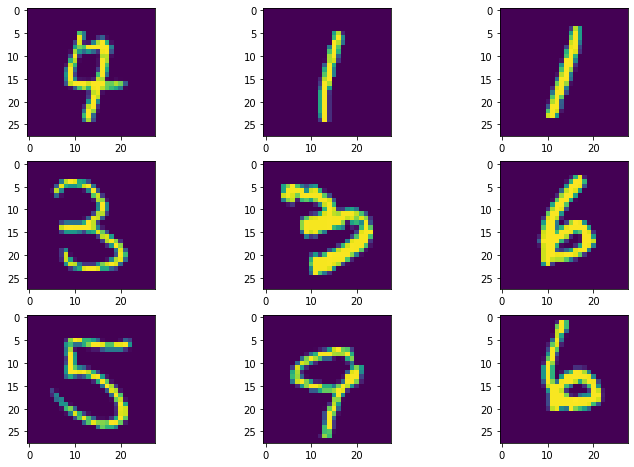

In [ ]:
plt.rcParams['figure.figsize']=(12,8)
for k in range(9):
    plt.subplot(3,3,k+1)
    plt.imshow(x_train[k,:,:,0])

In [ ]:
#Split the data in n_labels labeled samples and the rest as unlabeled 
def prepare_semi_data(x,y,n_labels):
  idx = np.random.choice(range(np.shape(y)[0]),n_labels, replace=False)
  y_label = np.array([y[k] for k in idx])
  y_unlabel = np.array([y[k] for k in range(np.shape(y)[0]) if k not in idx])
  x_label = np.array([x[k] for k in idx])
  x_unlabel = np.array([x[k] for k in range(np.shape(y)[0]) if k not in idx])
  return x_label,x_unlabel,y_label,y_unlabel

In [ ]:
#Split of the dataset with n_labels=100 for 100 labeled samples
x_label,x_unlabel,y_label,y_unlabel = prepare_semi_data(x_train,y_train,100)

Definition of the architecture of the model

In [ ]:
#network architecture CNN definition (drop outs necessary for pi-model to work)
def net(x,weights,biases,is_training,keep_prob):  

    layer1 = tf.nn.conv2d(input=x,filter=weights['conv1w1'],strides=[1, 1, 1, 1], padding='SAME')
    layer1 = tf.layers.batch_normalization(layer1,training=is_training)
    layer1 = tf.nn.dropout(layer1, keep_prob)
    layer1 = tf.nn.conv2d(input=layer1,filter=weights['conv1w2'],strides=[1, 2, 2, 1], padding='SAME')
    layer1 = tf.layers.batch_normalization(layer1,training=is_training)
    layer1 = tf.nn.leaky_relu(layer1,alpha=0.1)

    layer2 = tf.nn.conv2d(input=layer1,filter=weights['conv2w1'],strides=[1, 1, 1, 1], padding='SAME')
    layer2 = tf.layers.batch_normalization(layer2,training=is_training)
    layer2 = tf.nn.dropout(layer2, keep_prob)
    layer2 = tf.nn.conv2d(input=layer2,filter=weights['conv2w2'],strides=[1, 2, 2, 1], padding='SAME')
    layer2 = tf.layers.batch_normalization(layer2,training=is_training)
    layer2 = tf.nn.leaky_relu(layer2,alpha=0.1)
    
    layer_shape = layer2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer2, [-1, num_features])

    fc1 = tf.add(tf.matmul(layer_flat, weights['fc1_w']), biases['fc1_b'])
    fc1 = tf.layers.batch_normalization(fc1,training=is_training)
    fc1 = tf.nn.leaky_relu(fc1,alpha=0.1, name='fc1')
    fc1 = tf.nn.dropout(fc1, keep_prob)

    output_layer = tf.add(tf.matmul(fc1, weights['out_w']), biases['out_b'],name='output')
    return output_layer

In [ ]:
def train(X_train_label, y_train_label, X_train_unlabel,X_test,y_test, display_step = 1,training_epochs = 30, batch_size = 128, semi=True):

    tf.reset_default_graph()
    
    #Inputs of the model
    X_label = tf.placeholder(tf.float32, shape=[None, X_train_label.shape[1], X_train_label.shape[2], X_train_label.shape[3]])
    X_unlabel = tf.placeholder(tf.float32, shape=[None, X_train_label.shape[1], X_train_label.shape[2], X_train_label.shape[3]])
    Y_label = tf.placeholder(tf.uint8, shape=[None, n_classes])
    
    #Hyperparameters
    W = tf.placeholder(tf.float32,shape=None)

    #Dropout train (p=0.5) and test time (p=1)
    keep_prob = tf.placeholder(tf.float32)
    keep_prob_v_training = 0.5

    #Update parameters train (true) and test time (false)
    is_training = tf.placeholder(tf.bool)

    #Number of batches
    total_batches=len(X_train_unlabel)//batch_size
    
    
    #Parameters
    weights = {
        'conv1w1': tf.get_variable('Wc11', shape=[3, 3, 1, 32], initializer=tf.initializers.truncated_normal()),
        'conv1w2': tf.get_variable('Wc12', shape=[5, 5, 32, 32], initializer=tf.initializers.truncated_normal()),
        'conv2w1': tf.get_variable('Wc21', shape=[3, 3, 32, 64], initializer=tf.initializers.truncated_normal()),
        'conv2w2': tf.get_variable('Wc22', shape=[3, 3, 64, 64], initializer=tf.initializers.truncated_normal()),
        'fc1_w': tf.get_variable('W1', shape=(3136, 128), initializer=tf.initializers.truncated_normal()),
        'out_w': tf.get_variable('W_out',shape=(128, 10), initializer=tf.initializers.truncated_normal())
    }

    biases = {
        'fc1_b': tf.get_variable('B1',shape=(128),initializer=tf.keras.initializers.RandomNormal()),
        'out_b': tf.get_variable('B_out',shape=(10),initializer=tf.keras.initializers.RandomNormal())
    }
    
    #labeled data loss
    pred_label = net(X_label,weights,biases,is_training,keep_prob)
    pred_label_tild = net(X_label,weights,biases,is_training,keep_prob)
    loss_cross = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred_label, labels=Y_label))
    loss_label_sq =  tf.math.minimum(10*0.01,0.1*W*tf.reduce_mean((tf.nn.softmax(pred_label) - tf.nn.softmax(pred_label_tild))**2))
    loss_label = loss_cross + loss_label_sq

    #unlabeled data loss
    pred_unlabel = net(X_unlabel,weights,biases,is_training,keep_prob)
    pred_unlabel_tild = net(X_unlabel,weights,biases,is_training,keep_prob)
    loss_unlabel_sq =  tf.math.minimum(10*0.01,0.1*W*tf.reduce_mean((tf.nn.softmax(pred_unlabel) - tf.nn.softmax(pred_unlabel_tild))**2))
    loss_unlabel = loss_unlabel_sq

    #Compute the average of the loss across all the dimensions
    cost = tf.cond(is_training,lambda : loss_label + loss_unlabel, lambda : loss_label)

    #optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        trainer = tf.train.AdamOptimizer()
        optimizer = trainer.minimize(cost)
        
    correct_prediction = tf.equal(tf.argmax(tf.nn.softmax(pred_label),1), tf.argmax(Y_label, 1))

    #Calculate the accuracy across all the given batch and average them out. 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    config = tf.ConfigProto(log_device_placement=True,allow_soft_placement=True)
    #config.gpu_options.allow_growth = True
    
    with tf.device("/gpu:0"):
        with tf.Session(config=config) as sess:
            
            sess.run(init) 
                
            train_accuracy=[]
            train_loss=[]
            test_accuracy=[]
            test_loss=[]         

            for epoch in range(training_epochs):
                avg_cost, avg_acc= 0,0
                
                if semi:
                  #shuffle unlabel index
                  index = np.arange(X_train_unlabel.shape[0])
                  np.random.shuffle(index)
                  batch_X_unlabel = np.array_split(X_train_unlabel[index], total_batches)

                # rampup factor  setting
                w = np.exp(-5*(1-epoch/80)**2)

                for batch in range(total_batches):

                    batch_x_unlabel = batch_X_unlabel[batch]

                    #shuffle label index
                    index = np.random.choice(np.arange(X_train_label.shape[0]),replace=False,size=batch_size//4)
                    batch_X_label = X_train_label[index]
                    batch_y_label = y_train_label[index]

                    # Calculate batch loss and accuracy
                    sess.run(optimizer, feed_dict={X_label: batch_X_label,Y_label: batch_y_label, X_unlabel:batch_x_unlabel, W:w,
                                                           is_training:True,keep_prob:keep_prob_v_training})
                # Calculate batch loss and accuracy after an epoch on the train and validation set
                avg_cost,avg_acc = sess.run([cost, accuracy], feed_dict={X_label: batch_X_label,Y_label: batch_y_label, X_unlabel:batch_x_unlabel, W:w,
                                                       is_training:False,keep_prob:1})
                train_accuracy.append(avg_acc)
                train_loss.append(avg_cost)

                loss_test,acc_test = sess.run([cost, accuracy], 
                                                feed_dict={X_label: X_test,Y_label: y_test, X_unlabel:batch_x_unlabel, W:w,is_training:False,keep_prob:1})
                test_accuracy.append(acc_test)
                test_loss.append(loss_test)
                
                if (epoch % display_step == 0) or (epoch == (training_epochs-1)):
                    print('| Epoch: {}/{} | Train: Loss {:.6f} Accuracy : {:.6f} '\
                    '| Test: Loss {:.6f} Accuracy : {:.6f}\n'.format(
                    epoch+1, training_epochs,avg_cost, avg_acc,loss_test,acc_test)) 
            
            return {'train_accuracy':train_accuracy,'train_loss':train_loss,
                    'test_accuracy':test_accuracy,'test_loss':test_loss}

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

| Epoch: 1/30 | Train: Loss 0.087025 Accuracy : 0.968750 | Test: Loss 1.594695 Accuracy : 0.701600

| Epoch: 2/30 | Train: Loss 0.007943 Accuracy : 1.000000 | Test: Loss 1.385776 Accuracy : 0.751000

| Epoch: 3/30 | Train: Loss 0.000057 Accuracy : 1.000000 | Test: Loss 1.335035 Accuracy : 0.767700

| Epoch: 4/30 | Train: Loss 0.000004 Accuracy : 1.000000 | Test: Loss 1.337582 Accuracy : 0.779300

| Epoch: 5/30 | Train: Loss 0.000110 Accuracy : 1.000000 | Test: Loss 1.361220 Accuracy : 0.780300

| Epoch: 6/30 | Train: Loss 0.000044 Accuracy : 1.000000 | Test: Loss 1.370252 Accuracy : 0.783700

| Epoch: 7/30 | Train: Loss 0.000020 Accuracy : 1.000000 | Test: Loss 1.383327 Accuracy : 0.7850

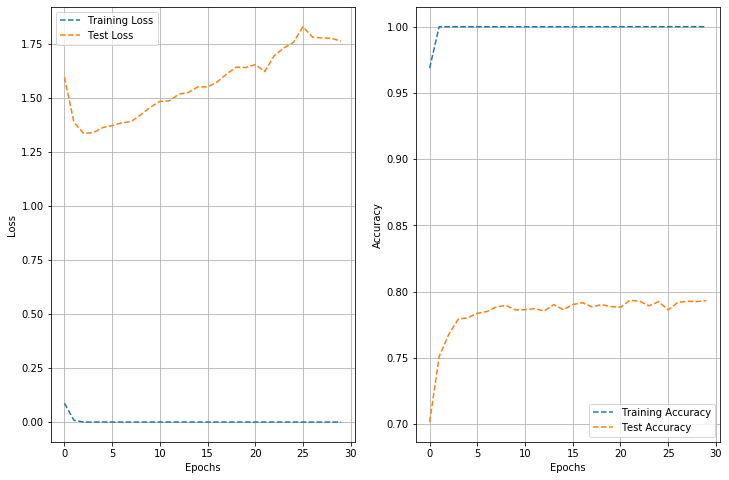

In [ ]:
result = train(X_train_label=x_label, y_train_label=y_label,X_train_unlabel=x_unlabel,X_test=x_val,y_test=y_val)
plt.subplot(1,2,1)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(result['train_loss'], label='Training Loss', linestyle='--')
plt.plot(result['test_loss'],  label='Test Loss',linestyle='--')
plt.legend()
plt.subplot(1,2,2)
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(result['train_accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(result['test_accuracy'],  label='Test Accuracy', linestyle='--')
plt.legend()

#### Underlying CNN architecture trained in supervised learning with 100 labels

In [ ]:
def net_superv(x,weights,biases,is_training,keep_prob):  
    
    layer1 = tf.nn.conv2d(input=x,filter=weights['conv1w1'],strides=[1, 1, 1, 1], padding='SAME')
    layer1 = tf.layers.batch_normalization(layer1,training=is_training)
    layer1 = tf.nn.dropout(layer1, keep_prob)
    layer1 = tf.nn.conv2d(input=layer1,filter=weights['conv1w2'],strides=[1, 2, 2, 1], padding='SAME')
    layer1 = tf.layers.batch_normalization(layer1,training=is_training)
    layer1 = tf.nn.leaky_relu(layer1,alpha=0.1)

    layer2 = tf.nn.conv2d(input=layer1,filter=weights['conv2w1'],strides=[1, 1, 1, 1], padding='SAME')
    layer2 = tf.layers.batch_normalization(layer2,training=is_training)
    layer2 = tf.nn.dropout(layer2, keep_prob)
    layer2 = tf.nn.conv2d(input=layer2,filter=weights['conv2w2'],strides=[1, 2, 2, 1], padding='SAME')
    layer2 = tf.layers.batch_normalization(layer2,training=is_training)
    layer2 = tf.nn.leaky_relu(layer2,alpha=0.1)
    
    layer_shape = layer2.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer2, [-1, num_features])


    fc1 = tf.add(tf.matmul(layer_flat, weights['fc1_w']), biases['fc1_b'])
    fc1 = tf.layers.batch_normalization(fc1,training=is_training)
    fc1 = tf.nn.leaky_relu(fc1,alpha=0.1, name='fc1')
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    output_layer = tf.add(tf.matmul(fc1, weights['out_w']), biases['out_b'],name='output')
    return output_layer

In [ ]:
def train_superv(X_train, y_train,X_test,y_test, display_step = 1,training_epochs = 1000, batch_size = 32):

    tf.reset_default_graph()
    
    #Inputs of the model
    X = tf.placeholder(tf.float32, shape=[None, X_train.shape[1], X_train.shape[2], X_train.shape[3]])
    Y = tf.placeholder(tf.uint8, shape=[None, n_classes])

    #Hyperparameters
    keep_prob = tf.placeholder(tf.float32) #Dropout train (p=0.5) and test time (p=0.5)
    is_training = tf.placeholder(tf.bool) #BatchNormalization train (true) and test time (false)
    total_batches=len(X_train)//batch_size
    keep_prob_v_training = 0.5
    
    #Parameters
    weights = {
        'conv1w1': tf.get_variable('Wc11', shape=[3, 3, 1, 32], initializer=tf.initializers.truncated_normal()),
        'conv1w2': tf.get_variable('Wc12', shape=[5, 5, 32, 32], initializer=tf.initializers.truncated_normal()),
        'conv2w1': tf.get_variable('Wc21', shape=[3, 3, 32, 64], initializer=tf.initializers.truncated_normal()),
        'conv2w2': tf.get_variable('Wc22', shape=[3, 3, 64, 64], initializer=tf.initializers.truncated_normal()),
        'fc1_w': tf.get_variable('W1', shape=(3136, 128), initializer=tf.initializers.truncated_normal()),
        'out_w': tf.get_variable('W_out',shape=(128, 10), initializer=tf.initializers.truncated_normal())
    }

    biases = {
        'fc1_b': tf.get_variable('B1',shape=(128),initializer=tf.keras.initializers.RandomNormal()),
        'out_b': tf.get_variable('B_out',shape=(10),initializer=tf.keras.initializers.RandomNormal())
    }
    
    pred = net_superv(X,weights,biases,is_training,keep_prob)

    #Compute the average of the loss across all the dimensions
    supervised = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
    
    cost = supervised

    #optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        trainer = tf.train.AdamOptimizer()
        optimizer = trainer.minimize(cost)
        
    correct_prediction = tf.equal(tf.argmax(pred,1), tf.argmax(Y, 1))

    #Calculate the accuracy across all the given batch and average them out. 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Initializing the variables
    init = tf.global_variables_initializer()
    
    config = tf.ConfigProto(log_device_placement=True,allow_soft_placement=True)
    
    with tf.device("/gpu:0"):
        with tf.Session(config=config) as sess:
            
            sess.run(init) 
              
            train_accuracy=[]
            train_loss=[]
            test_accuracy=[]
            test_loss=[]         

            for epoch in range(training_epochs):
                avg_cost, avg_acc= 0,0
                
#                 Shuffling the index
                index = np.arange(X_train.shape[0])
                np.random.shuffle(index)
                batch_X = np.array_split(X_train[index], total_batches)
                batch_Y = np.array_split(y_train[index], total_batches)
                
                for batch in range(total_batches):

                    batch_x,batch_y=batch_X[batch],batch_Y[batch]
                    sess.run(optimizer, feed_dict={X: batch_x,Y: batch_y,
                                                           is_training:True,keep_prob:keep_prob_v_training})
                    
                # Calculate batch loss and accuracy after an epoch on the train and validation set
                
                avg_cost,avg_acc = sess.run([cost, accuracy], feed_dict={X: X_train,Y: y_train, 
                                                       is_training:False,keep_prob:1})
                train_accuracy.append(avg_acc)
                train_loss.append(avg_cost)

                loss_test,acc_test = sess.run([cost, accuracy], 
                                                feed_dict={X: X_test,Y: y_test,is_training:False,keep_prob:1})
                test_accuracy.append(acc_test)
                test_loss.append(loss_test)
        
                if (epoch % display_step == 0) or (epoch == (training_epochs-1)):
                    print('| Epoch: {}/{} | Train: Loss {:.6f} Accuracy : {:.6f} '\
                    '| Test: Loss {:.6f} Accuracy : {:.6f}\n'.format(
                    epoch+1, training_epochs,avg_cost, avg_acc,loss_test,acc_test)) 
            
            return {'train_accuracy':train_accuracy,'train_loss':train_loss,
                    'test_accuracy':test_accuracy,'test_loss':test_loss}

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

| Epoch: 1/1000 | Train: Loss 5270.312988 Accuracy : 0.110000 | Test: Loss 5001.853516 Accuracy : 0.106000

| Epoch: 2/1000 | Train: Loss 1441.747681 Accuracy : 0.110000 | Test: Loss 1391.274536 Accuracy : 0.110000

| Epoch: 3/1000 | Train: Loss 654.272705 Accuracy : 0.110000 | Test: Loss 638.812012 Accuracy : 0.111000

| Epoch: 4/1000 | Train: Loss 373.732727 Accuracy : 0.110000 | Test: Loss 369.698486 Accuracy : 0.113000

| Epoch: 5/1000 | Train: Loss 237.179214 Accuracy : 0.130000 | Test: Loss 237.997299 Accuracy : 0.116000

| Epoch: 6/1000 | Train: Loss 163.325912 Accuracy : 0.130000 | Test: Loss 166.351608 Accuracy : 0.116000

| Epoch: 7/1000 | Train: Loss 119.501389 Accuracy : 0.13

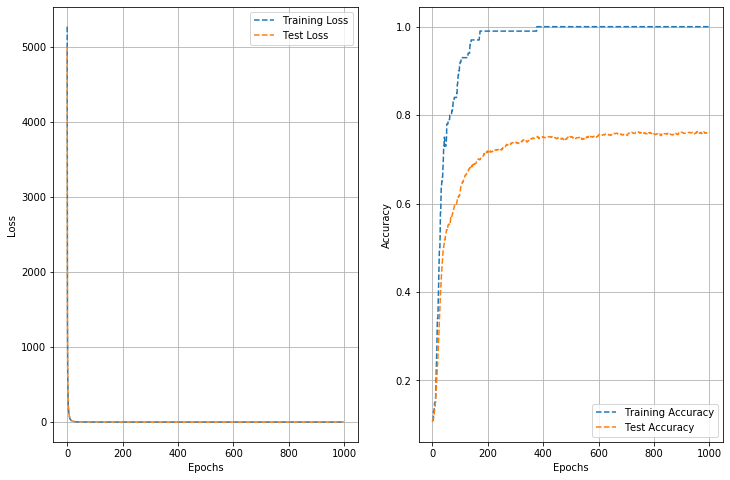

In [ ]:
result = train_superv(X_train=x_label, y_train=y_label,X_test=x_val,y_test=y_val)
plt.subplot(1,2,1)
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(result['train_loss'], label='Training Loss', linestyle='--')
plt.plot(result['test_loss'],  label='Test Loss',linestyle='--')
plt.legend()
plt.subplot(1,2,2)
plt.grid(True)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(result['train_accuracy'], label='Training Accuracy', linestyle='--')
plt.plot(result['test_accuracy'],  label='Test Accuracy', linestyle='--')
plt.legend()